In [1]:
!pip install -q transformers datasets evaluate


In [2]:
!pip install --upgrade transformers



In [3]:
%env CUDA_VISIBLE_DEVICES

UsageError: Environment does not have key: CUDA_VISIBLE_DEVICES


In [1]:
%env CUDA_VISIBLE_DEVICES=2

env: CUDA_VISIBLE_DEVICES=2


In [2]:
%env CUDA_VISIBLE_DEVICES

'2'

In [3]:
import os
import torch
import numpy as np
import json
import matplotlib.pyplot as plt
from PIL import Image

In [4]:
from structures.dataset_structure import COCOSegmentationDataset
from utils.data_preprocessor_utils import *
from utils.visualize_utils import *

In [5]:
# Car_damages_dataset, Car_parts_dataset
dataset = "Car_damages_dataset"

if(dataset == "Car_damages_dataset"):
    coco_path = "coco_damage_annotations.json"
elif(dataset == "Car_parts_dataset"):
    coco_path = "coco_parts_annotations.json"

In [6]:
datadir = "./data/car-parts-and-car-damages/"

car_dir = os.path.join(datadir,dataset)
car_imgs = os.path.join(car_dir,"split_dataset")
car_anns = os.path.join(car_dir,"split_annotations")

In [7]:
car_id_to_color = get_colormapping(os.path.join(car_dir,coco_path),car_dir+"/meta.json")
car_id_to_color

loading annotations into memory...
Done (t=0.22s)
creating index...
index created!


{3: '#13A4C9',
 2: '#A6FF47',
 6: '#B42D38',
 8: '#E19660',
 1: '#903C59',
 7: '#A7741B',
 4: '#B40E13',
 5: '#73C2CE'}

In [14]:
is_normalize_image=False
# Create dataset
train_car_dataset = get_dataset(car_imgs,car_anns,is_train=True)
val_car_dataset = get_dataset(car_imgs,car_anns)


root  ./data/car-parts-and-car-damages/Car_damages_dataset/split_dataset/train
ann_file  ./data/car-parts-and-car-damages/Car_damages_dataset/split_annotations/train.json
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
root  ./data/car-parts-and-car-damages/Car_damages_dataset/split_dataset/val
ann_file  ./data/car-parts-and-car-damages/Car_damages_dataset/split_annotations/val.json
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [15]:
# Check an example
image, mask = train_car_dataset[90]
print(image.shape, mask.shape,train_car_dataset.img_path)  # Tensor dimensions

torch.Size([3, 594, 800]) torch.Size([1, 594, 800]) ./data/car-parts-and-car-damages/Car_damages_dataset/split_dataset/train/Car damages 139.png


In [16]:
# with open('./mask.txt', 'w') as f:
#     for m in mask.numpy()[0]:
#         f.write("%s\n" % m)

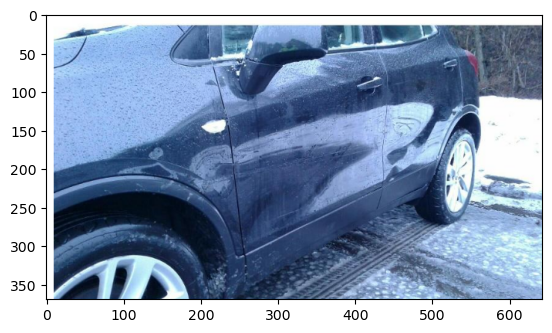

In [17]:
plt.imshow(Image.open(train_car_dataset.img_path))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


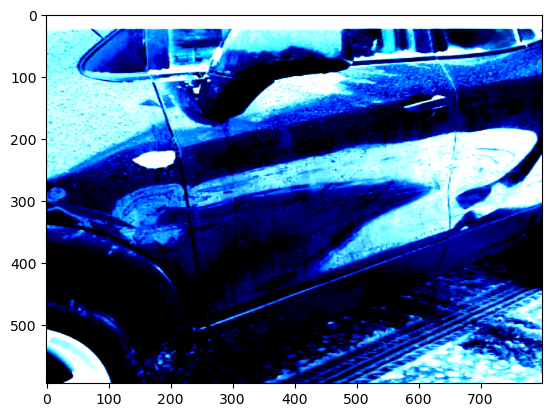

In [18]:
if(is_normalize_image):
    plt.imshow(unnormalize_image(image.transpose(0,-1).transpose(0,1).numpy()))
else:
    plt.imshow(image.transpose(0,-1).transpose(0,1).numpy())

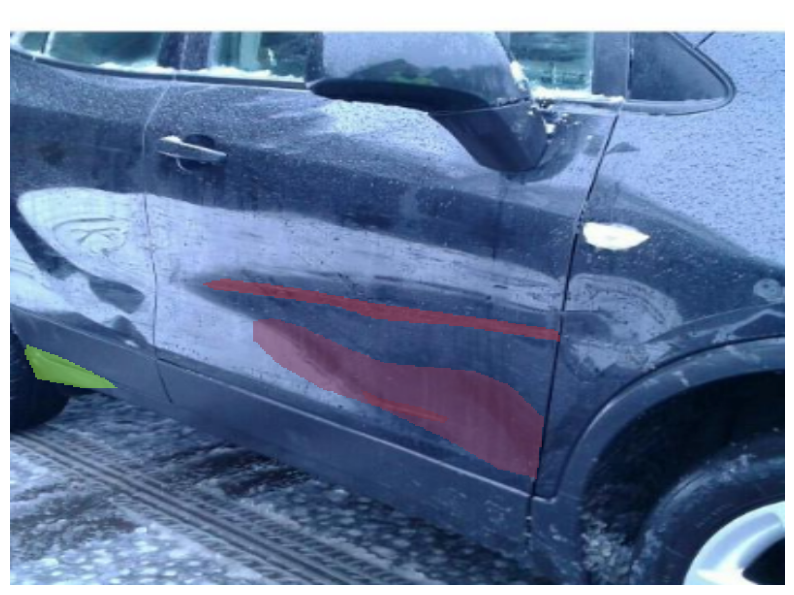

In [13]:
overlayed_image = overlay_colored_mask(image.transpose(0,-1).transpose(0,1).numpy(), mask[0].numpy(), car_id_to_color, alpha=0.5,is_normalize_image=is_normalize_image)

# Visualize the result
plt.figure(figsize=(10, 10))
plt.imshow(overlayed_image)
plt.axis('off')
plt.show()

In [16]:
from torch.utils.data import DataLoader

# Create DataLoader
tr_cd_dataloader = DataLoader(train_car_dataset, batch_size=2, shuffle=True)
val_cd_dataloader = DataLoader(val_car_dataset, batch_size=2)

In [17]:
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation
from PIL import Image
from car_segmentation import get_segformermodel,get_model_from_path,evaluate_model
from structures.heirarchical_seg_model import Hierarchical_SegModel,Fusion_SegModel

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

2025-01-04 17:00:16.913338: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-04 17:00:17.899674: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/akshay/.conda/envs/research-work-DAG-DNN/lib/python3.7/site-packages/cv2/../../lib64:
2025-01-04 17:00:17.899776: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/akshay/.conda/envs/research-work

In [14]:
# None, 'hierarchical' , 'fusion'
model_type = None

pretrained_model_name = "nvidia/segformer-b5-finetuned-cityscapes-1024-1024"
# pretrained_model_name = "nvidia/segformer-b5-finetuned-ade-640-640"
start_net_path="./checkpoints/contrast1/nvidia_segformer-b5-finetuned-cityscapes-1024-1024_ep_54.pt"

superseg_model_name = "nvidia/segformer-b3-finetuned-cityscapes-1024-1024"
super_segmodel_path = "./checkpoints/Car_parts_dataset/nvidia_segformer-b3-finetuned-cityscapes-1024-1024_ep_90.pt"
if(model_type is None):
    model = get_segformermodel(len(car_id_to_color),pretrained_model_name)
elif(model_type == 'hierarchical' or model_type == 'fusion'):
    superseg_ds = "Car_parts_dataset"
    superseg_dir = os.path.join(datadir,superseg_ds)
    superseg_id_to_color = get_colormapping(os.path.join(superseg_dir,get_cocopath(superseg_ds)),superseg_dir+"/meta.json")
    super_segmodel = get_segformermodel(len(superseg_id_to_color),superseg_model_name)
    super_segmodel,_ = get_model_from_path(super_segmodel,super_segmodel_path)
    if(model_type=='hierarchical'):
        model = Hierarchical_SegModel(super_segmodel,len(superseg_id_to_color)+1,len(car_id_to_color)+1,pretrained_model_name)
    elif(model_type == 'fusion'):
        model = Fusion_SegModel(super_segmodel,len(superseg_id_to_color)+1,len(car_id_to_color)+1,pretrained_model_name)
model,_ = get_model_from_path(model,start_net_path)


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b5-finetuned-cityscapes-1024-1024 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([19, 768, 1, 1]) in the checkpoint and torch.Size([9, 768, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([19]) in the checkpoint and torch.Size([9]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded from ./checkpoints/contrast1/nvidia_segformer-b5-finetuned-cityscapes-1024-1024_ep_54.pt


In [15]:
evaluate_model(model.cuda(),len(car_id_to_color),val_cd_dataloader)

Evaluating:   0%|          | 0/82 [00:00<?, ?it/s]/home/akshay/.conda/envs/research-work-DAG-DNN/lib/python3.7/site-packages/datasets/features/image.py:334: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")
/home/akshay/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:259: RuntimeWarning: invalid value encountered in true_divide
  iou = total_area_intersect / total_area_union
/home/akshay/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:260: RuntimeWarning: invalid value encountered in true_divide
  acc = total_area_intersect / total_area_label
Evaluating:   1%|          | 1/82 [00:01<01:56,  1.44s/it]/home/akshay/.conda/envs/research-work-DAG-DNN/

Validation loss: 0.2994419260450253 mean_iou :0.2619164769813001, mean_accuracy :0.2779255751050491 val_pixel_accuracy: 0.9252510881169418 val_dice_coeff : 0.5207684545255289


(0.2994419260450253,
 0.2619164769813001,
 0.2779255751050491,
 0.9252510881169418,
 0.5207684545255289)

In [16]:
evaluate_model(model.cuda(),len(car_id_to_color),tr_cd_dataloader)

Evaluating:   0%|          | 0/326 [00:00<?, ?it/s]/home/akshay/.conda/envs/research-work-DAG-DNN/lib/python3.7/site-packages/datasets/features/image.py:334: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")
/home/akshay/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:259: RuntimeWarning: invalid value encountered in true_divide
  iou = total_area_intersect / total_area_union
/home/akshay/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:260: RuntimeWarning: invalid value encountered in true_divide
  acc = total_area_intersect / total_area_label
Evaluating:   0%|          | 1/326 [00:01<07:43,  1.43s/it]/home/akshay/.conda/envs/research-work-DAG-DN

Validation loss: 0.11176903676698727 mean_iou :0.3281727623180602, mean_accuracy :0.37501078619653977 val_pixel_accuracy: 0.9652748310043175 val_dice_coeff : 0.6879388466020303


(0.11176903676698727,
 0.3281727623180602,
 0.37501078619653977,
 0.9652748310043175,
 0.6879388466020303)

In [23]:
iter_train = iter(val_cd_dataloader)

In [29]:
img,msk = next(iter_train)
msk=msk.squeeze(1)
img.size(),msk.size()

(torch.Size([2, 3, 594, 800]), torch.Size([2, 594, 800]))

In [30]:
import torch.nn.functional as F
model = model.cpu()
outputs = model(img,msk)
logits = outputs.logits
with torch.no_grad():
    upsampled_logits = F.interpolate(logits, size=msk.shape[-2:], mode="bilinear", align_corners=False)
    predicted = upsampled_logits.argmax(dim=1)


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:2                                                                                    │
│                                                                                                  │
│   1 import torch.nn.functional as F                                                              │
│ ❱ 2 model = model.cpu()                                                                          │
│   3 outputs = model(img,msk)                                                                     │
│   4 logits = outputs.logits                                                                      │
│   5 with torch.no_grad():                                                                        │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'model' is not defined

In [20]:
predicted.size(),msk.size(),upsampled_logits.size(),logits.size(),img.size()

(torch.Size([2, 594, 800]),
 torch.Size([2, 594, 800]),
 torch.Size([2, 9, 594, 800]),
 torch.Size([2, 9, 149, 200]),
 torch.Size([2, 3, 594, 800]))

In [26]:
ind=1

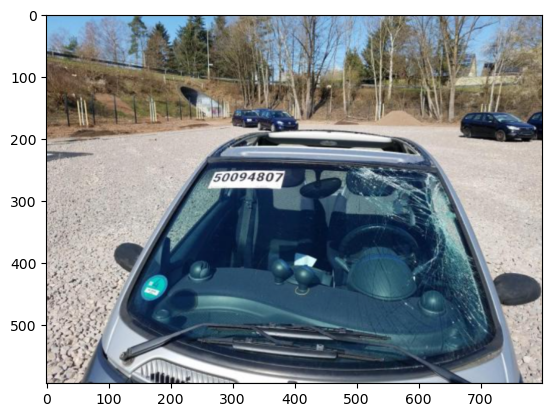

In [32]:
if(is_normalize_image):
    plt.imshow(unnormalize_image(img[ind].transpose(0,-1).transpose(0,1).numpy()))
else:
    plt.imshow(img[ind].transpose(0,-1).transpose(0,1).numpy())

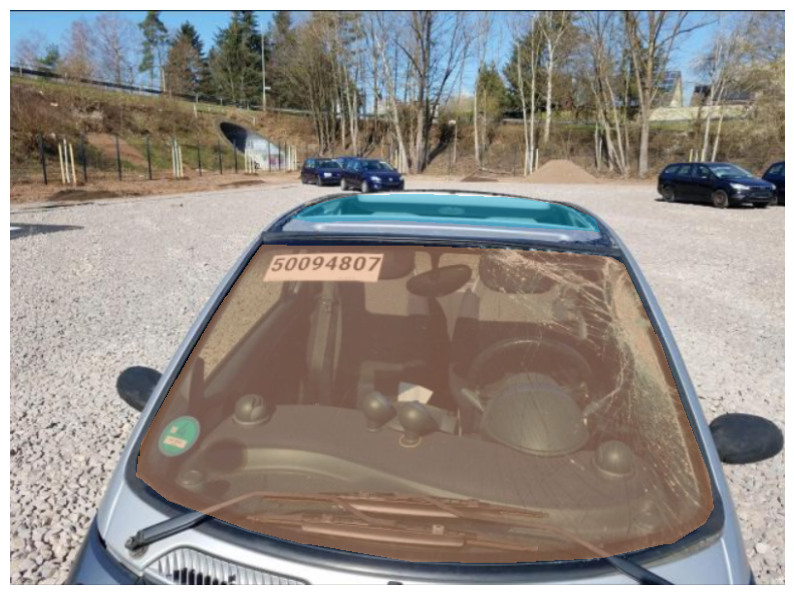

In [31]:
overlayed_image = overlay_colored_mask(img[ind].transpose(0,-1).transpose(0,1).numpy(), msk[ind].numpy(), car_id_to_color, alpha=0.5,is_normalize_image=is_normalize_image)

# Visualize the result
plt.figure(figsize=(10, 10))
plt.imshow(overlayed_image)
plt.axis('off')
plt.show()

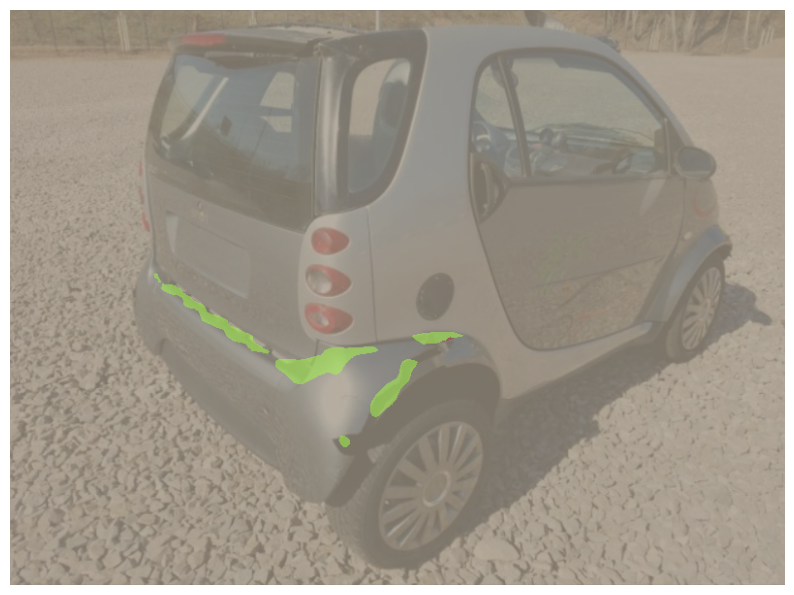

In [24]:
overlayed_image = overlay_colored_mask(img[ind].transpose(0,-1).transpose(0,1).numpy(), predicted[ind].numpy(), car_id_to_color, alpha=0.5,is_normalize_image=is_normalize_image)

# Visualize the result
plt.figure(figsize=(10, 10))
plt.imshow(overlayed_image)
plt.axis('off')
plt.show()

In [93]:
with open('./mask.txt', 'w') as f:
    for m in msk.numpy()[0]:
        f.write("%s\n" % m)

with open('./pred.txt', 'w') as f:
    for m in predicted.numpy()[0]:
        f.write("%s\n" % m)

2024-12-30 01:22:32.797693: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/akshay/.conda/envs/research-work-DAG-DNN/lib/python3.7/site-packages/cv2/../../lib64:
2024-12-30 01:22:32.797803: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/akshay/.conda/envs/research-work-DAG-DNN/lib/python3.7/site-packages/cv2/../../lib64:
2024-12-30 01:22:32.797814: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
/home/akshay/.conda/envs/research-work-DAG-DNN/lib/python3.7/

inputs  torch.Size([1, 3, 1024, 1024])
logits  torch.Size([1, 19, 256, 256])


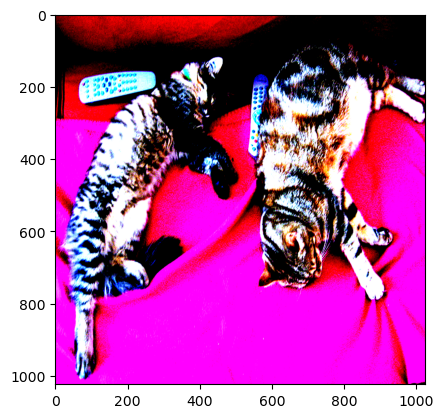

In [18]:
# from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation
# from PIL import Image
# import requests

# feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b5-finetuned-cityscapes-1024-1024")
# model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b5-finetuned-cityscapes-1024-1024")

# url = "http://images.cocodataset.org/val2017/000000039769.jpg"
# image = Image.open(requests.get(url, stream=True).raw)
# inputs = feature_extractor(images=image, return_tensors="pt")
# print("inputs ",inputs["pixel_values"].shape)
# plt.imshow(inputs["pixel_values"][0].transpose(0,-1).transpose(0,1).numpy())
# outputs = model(**inputs)
# logits = outputs.logits  # shape (batch_size, num_labels, height/4, width/4)
# print("logits ",logits.size())